# Imports

In [1]:
from pyabc import (ABCSMC, Distribution, RV,
                   History, Model,
                   ModelResult, MedianEpsilon)
from pyabc.transition import MultivariateNormalTransition
from pyabc.visualization import plot_kde_matrix
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%config Inline.Backend.figure_format = 'retina'
import os
import tempfile
import math
import pandas as pd
import scipy as sp
import numpy as np
import subprocess
from io import BytesIO

from pyabc_custom import MyokitSimulation
from prangle_distance import PrangleDistance,PranglePopulationSize,PrangleEpsilon

# Get experimental measurements

In [2]:
myokit_python = ('/tmp/chouston/miniconda3/envs' +
                 '/ion_channel_ABC/bin/python')
args = [myokit_python, 'get_measurements.py']
args.append('ito')
re = subprocess.run(args, stdout=subprocess.PIPE)
measurements = pd.read_table(BytesIO(re.stdout),
                             delim_whitespace=True,
                             header=0, index_col=False)
obs = measurements.to_dict()['y']
exp = measurements.to_dict()['exp']

# Set limits and generate uniform initial priors

In [3]:
limits = dict(g_to=(0, 1),
              k_xss1=(0, 10),
              k_xss2=(0, 100),
              k_xtau1=(0, 10),
              k_xtau2=(0, 100),
              k_xtau3=(0, 100),
              k_yss1=(0, 100),
              k_yss2=(0, 100),
              k_ytau1=(0, 100),
              k_ytau2=(0, 100),
              k_ytau3=(0, 100),
              k_ytau4=(0, 100))
prior = Distribution(**{key: RV("uniform", a, b - a)
                        for key, (a,b) in limits.items()})

# Define ABC parameters and initialise database

In [4]:
myokit_model = MyokitSimulation('ito')
#myokit_model.sample(prior.rvs())

In [18]:
db_path = ('sqlite:///' + 
           os.path.join(tempfile.gettempdir(), "hl-1_ito.db"))

In [19]:
abc = ABCSMC(models=myokit_model,
             parameter_priors=prior,
             distance_function=PrangleDistance(
                 exp_map=exp,
                 alpha=0.5,
                 delta=0.5,
                 adapt=False),
             population_size=PranglePopulationSize(
                 500, alpha=0.5,
                 adapt=True,
                 mean_cv=0.5,
                 min_population_size=200,
                 max_population_size=5000),
             eps=PrangleEpsilon(100, alpha=0.5))

In [32]:
abc_id = abc.new(db_path, obs)

INFO:Epsilon:initial epsilon is 100
INFO:History:Start <ABCSMC(id=3, start_time=2018-06-29 21:04:06.723905, end_time=None)>


In [36]:
history = abc.run(minimum_epsilon=0.01, max_nr_populations=10)

INFO:ABC:t:30 M eps:[100.          18.82600129  10.55043081   8.03061615   6.49165731
   5.44322283   4.6825719    4.05933733   3.65856133   3.32868526
   3.04161247   2.80754852   2.60950598   2.45222965   2.32631828
   2.22286946   2.13709368   2.06410156   1.99608827   1.92972371
   1.85016055   1.77073743   1.68865682   1.60701219   1.53340003
   1.46044396   1.38825995   1.30744437   1.1594879    1.09729585
   1.03359775]
INFO:Adaptation:Change nr particles 3058 -> 5000
INFO:ABC:t:30 N eps:0.9711501171458637
INFO:ABC:N population size: 5000
INFO:ABC:t:31 M eps:[100.          18.82600129  10.55043081   8.03061615   6.49165731
   5.44322283   4.6825719    4.05933733   3.65856133   3.32868526
   3.04161247   2.80754852   2.60950598   2.45222965   2.32631828
   2.22286946   2.13709368   2.06410156   1.99608827   1.92972371
   1.85016055   1.77073743   1.68865682   1.60701219   1.53340003
   1.46044396   1.38825995   1.30744437   1.1594879    1.09729585
   1.03359775   0.97115012]
INFO

KeyboardInterrupt: 

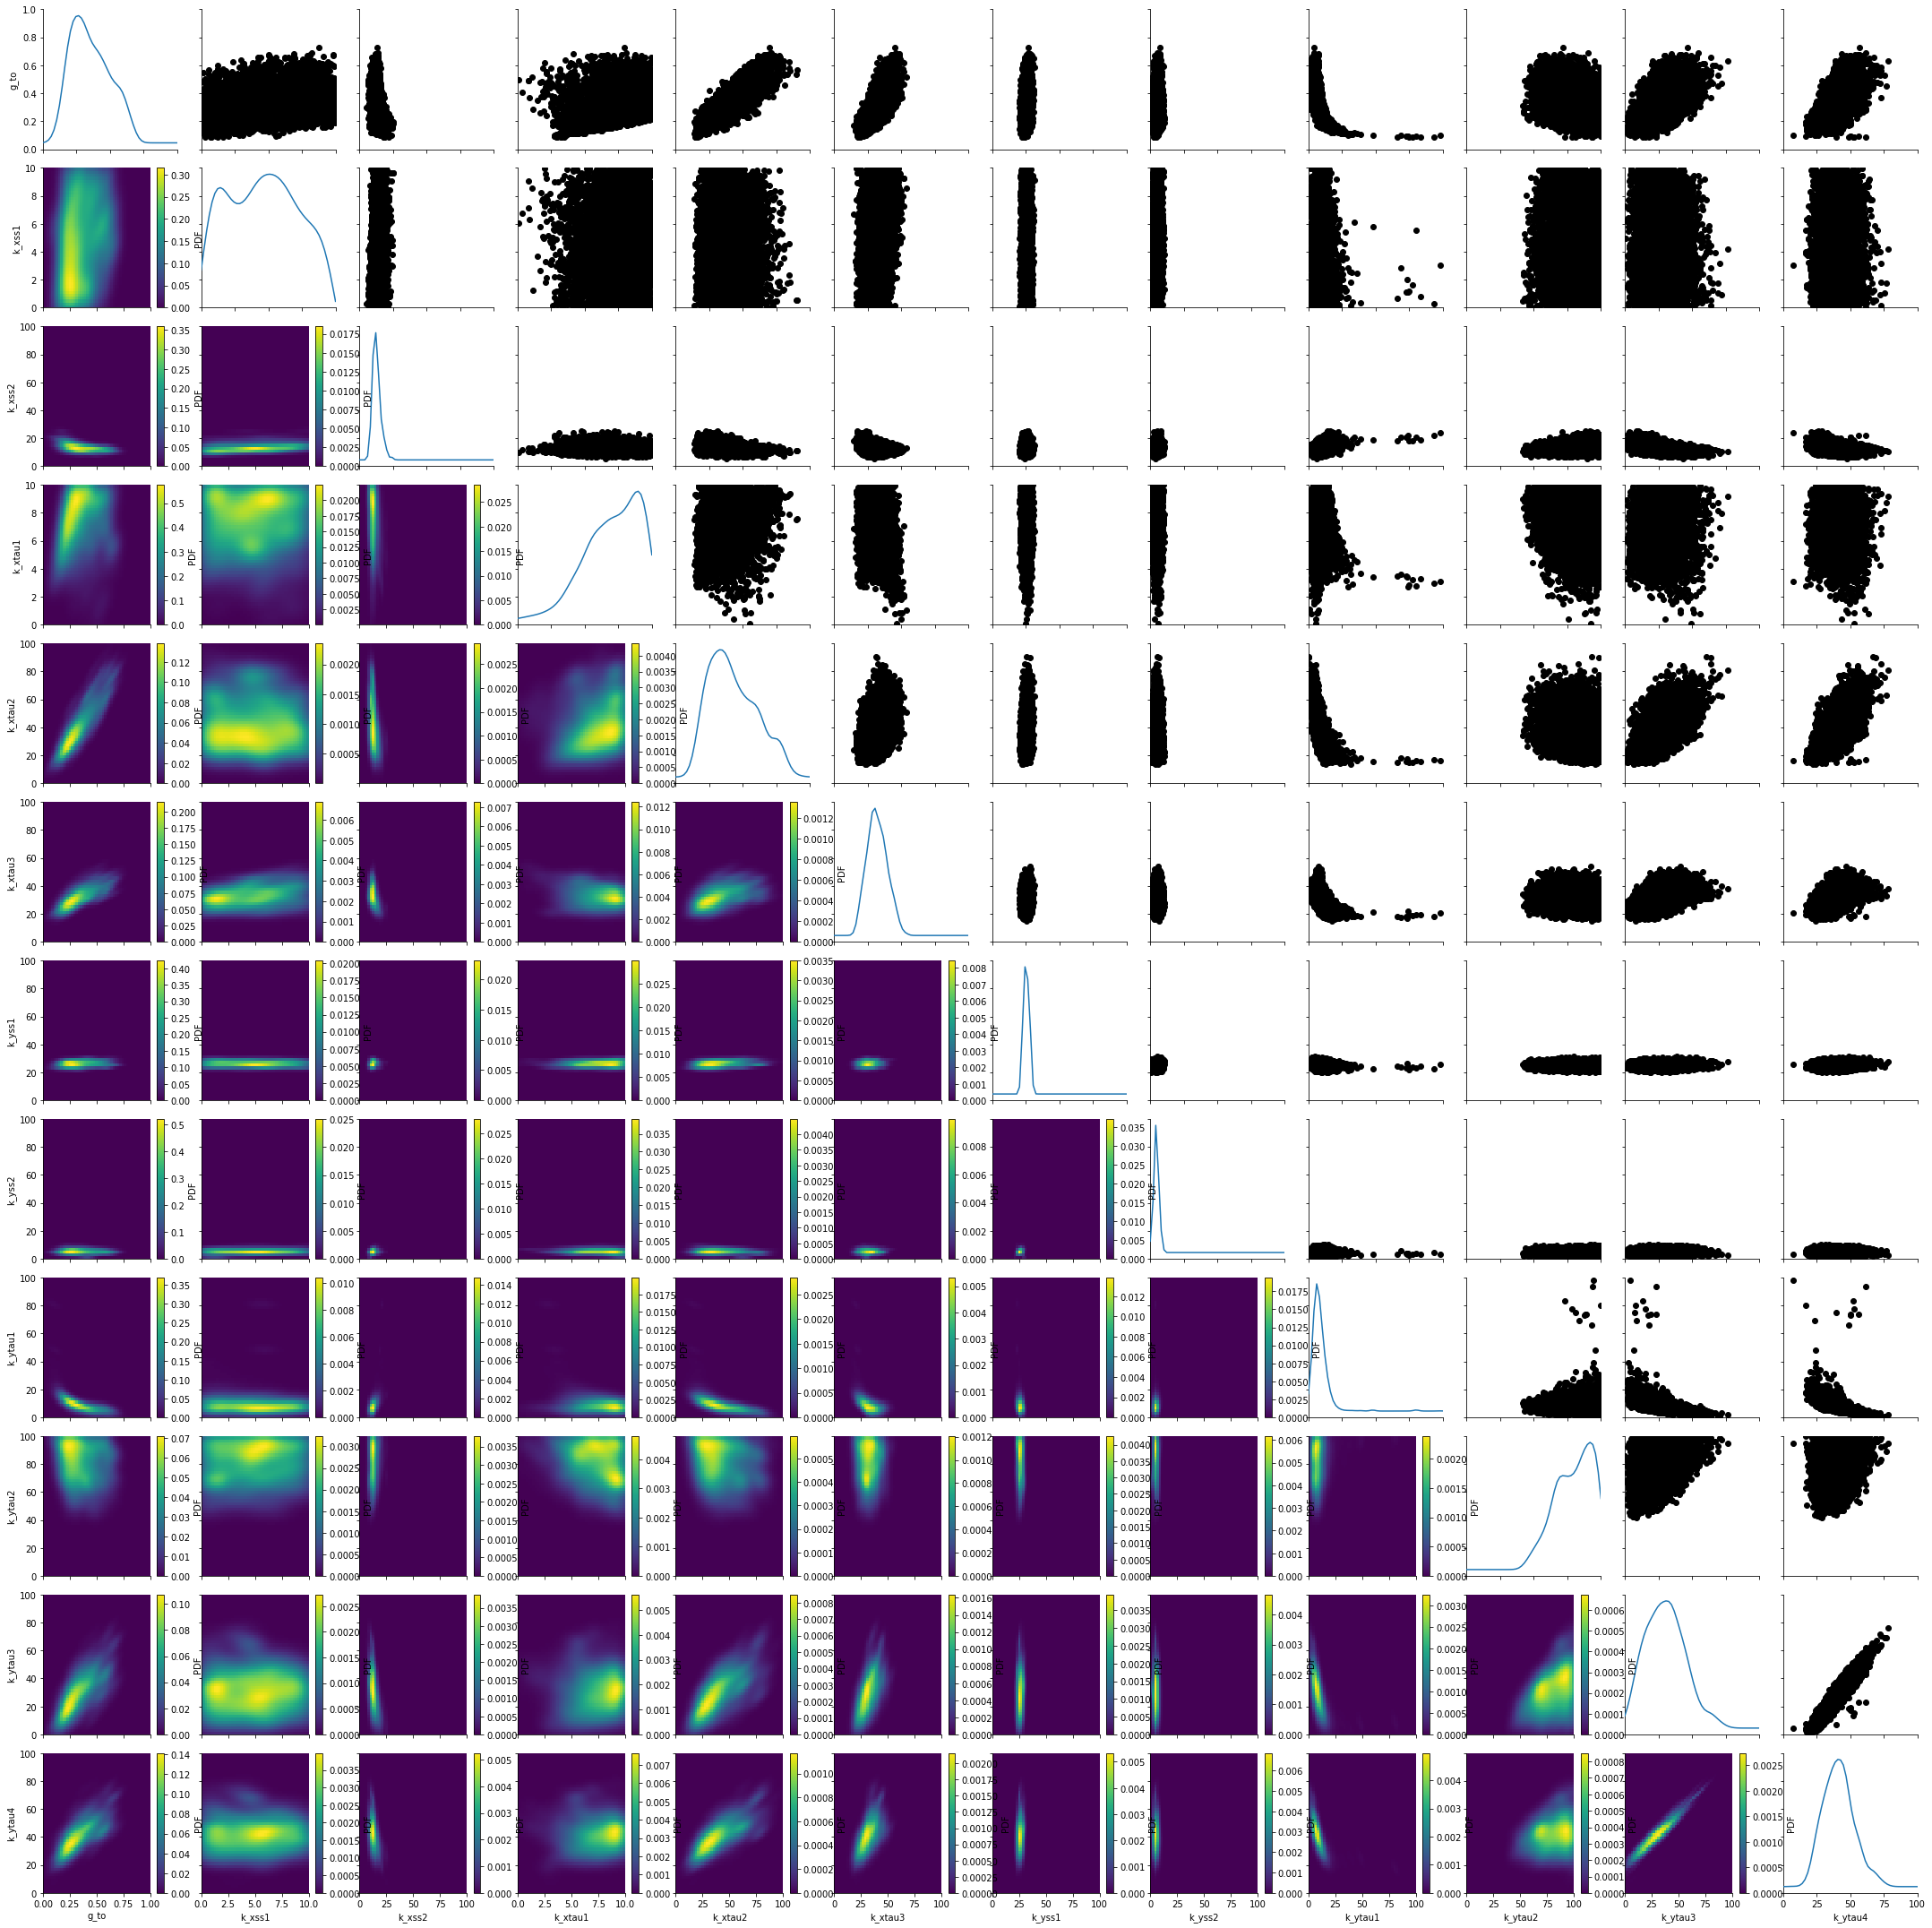

In [38]:
df, w = history.get_distribution(m=0)
plot_kde_matrix(df, w, limits=limits)

In [5]:
db_path = 'sqlite:///pyabc-runs/hl-1_ito.db'
history = History(db_path)
history.all_runs()

[<ABCSMC(id=1, start_time=2018-06-28 10:56:04.403119, end_time=2018-06-28 18:56:56.722533)>,
 <ABCSMC(id=2, start_time=2018-06-28 20:11:33.249842, end_time=2018-06-29 01:03:40.939122)>,
 <ABCSMC(id=3, start_time=2018-06-29 21:04:06.723905, end_time=2018-07-02 18:52:09.617382)>]

In [6]:
history.id = 3

In [7]:
df, w = history.get_distribution(m=0)
df['wt'] = w
print("Mean")
for key in limits.keys():
    print(key, ":", sum(df[key] * df.wt))
print("Min")
for key in limits.keys():
    print(key, ":", min(df[key]))
print("Max")
for key in limits.keys():
    print(key, ":", max(df[key]))

Mean
g_to : 0.35396639852010003
k_xss1 : 4.726643390161773
k_xss2 : 12.823376916476636
k_xtau1 : 7.141668691546454
k_xtau2 : 42.85572628713727
k_xtau3 : 32.22516195666456
k_yss1 : 25.562223302898133
k_yss2 : 4.514001008764314
k_ytau1 : 8.560535828892828
k_ytau2 : 79.9533952717288
k_ytau3 : 30.144585176355505
k_ytau4 : 41.46663615154224
Min
g_to : 0.08394256237461252
k_xss1 : 0.0006122764756166799
k_xss2 : 5.529633069726945
k_xtau1 : 0.07956962412622581
k_xtau2 : 13.510110643762278
k_xtau3 : 14.729917266162058
k_yss1 : 19.96106135500283
k_yss2 : 0.015354078532703763
k_ytau1 : 0.10982097115278044
k_ytau2 : 41.823546305783495
k_ytau3 : 0.0702703184856297
k_ytau4 : 7.466568236738107
Max
g_to : 0.7269569494614422
k_xss1 : 9.994503371115867
k_xss2 : 25.310561777654897
k_xtau1 : 9.999831730188923
k_xtau2 : 90.64795195090569
k_xtau3 : 53.66300534978699
k_yss1 : 31.46937190168813
k_yss2 : 10.500286633367338
k_ytau1 : 97.86676087482604
k_ytau2 : 99.98697689431948
k_ytau3 : 76.4880231110952
k_yta

/tmp/chouston/miniconda3/envs/pyabc/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


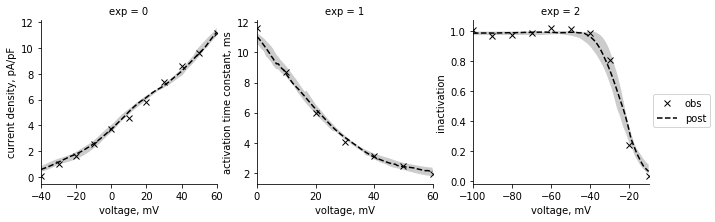

In [9]:
from visualization_custom import plot_sim_results
g = plot_sim_results(history, 'ito', n_samples=10, obs=measurements, original=False)
xlabels = ["voltage, mV", "voltage, mV", "voltage, mV"]
ylabels = ["current density, pA/pF", "activation time constant, ms", "inactivation"]
for ax, xl in zip(g.axes.flatten(), xlabels):
    ax.set_xlabel(xl)
for ax, yl in zip(g.axes.flatten(), ylabels):
    ax.set_ylabel(yl)
plt.savefig('ito_results.pdf', format='pdf', dpi=1000)

run
0     AxesSubplot(0.125,0.125;0.775x0.755)
1     AxesSubplot(0.125,0.125;0.775x0.755)
2     AxesSubplot(0.125,0.125;0.775x0.755)
3     AxesSubplot(0.125,0.125;0.775x0.755)
4     AxesSubplot(0.125,0.125;0.775x0.755)
5     AxesSubplot(0.125,0.125;0.775x0.755)
6     AxesSubplot(0.125,0.125;0.775x0.755)
7     AxesSubplot(0.125,0.125;0.775x0.755)
8     AxesSubplot(0.125,0.125;0.775x0.755)
9     AxesSubplot(0.125,0.125;0.775x0.755)
10    AxesSubplot(0.125,0.125;0.775x0.755)
11    AxesSubplot(0.125,0.125;0.775x0.755)
12    AxesSubplot(0.125,0.125;0.775x0.755)
13    AxesSubplot(0.125,0.125;0.775x0.755)
14    AxesSubplot(0.125,0.125;0.775x0.755)
dtype: object

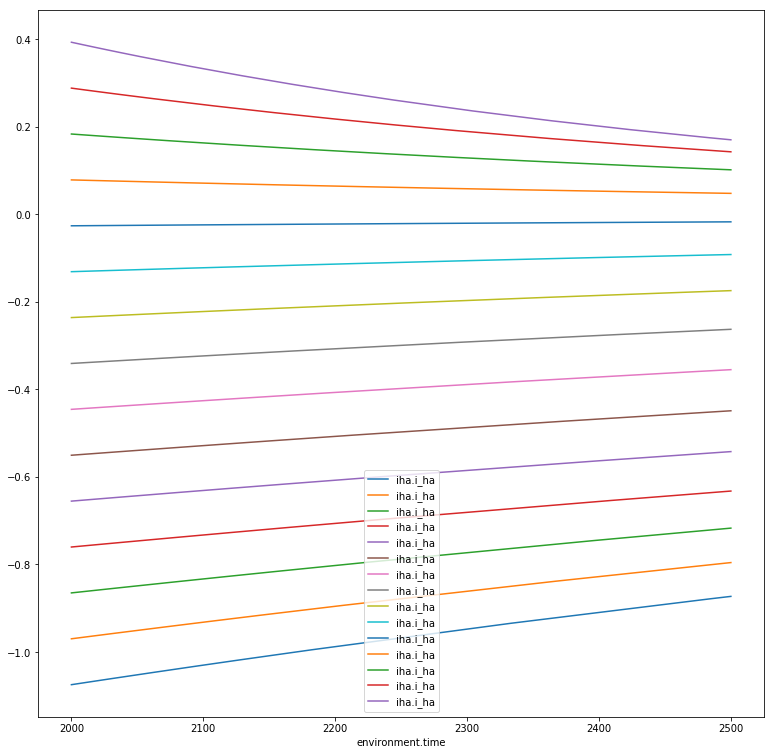

In [21]:
from pyabc_custom import simulate
out = simulate('iha', experiment=0, logvars=['environment.time', 'iha.i_ha'])
fig,ax = plt.subplots(figsize=(13,13))
out.groupby("run").plot(x="environment.time", y="iha.i_ha",ax=ax)